# Statistical Modelling : (AutoRegressive Integrated Moving Average) ARIMA Model

**Author :** Muhammad Faran Khalid

In this notebook I use ARIMA model to predict the 'Total Waterflow' for the lake **(MD-MVM Id : 54)** from January 2022 to December 2025. I'm using the ***statsmodels*** library.

In [2]:
# imports
import pandas as pd
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset

# Loading and Cleaning Dataset

The dataset I'm using contains the hydrology data for the lake **(MD-MVM Id : 54)**. The rows with non-standard enteries are removed along with converting the 'Date' column to datetime format.

In [3]:
# Loading merged weather and hydrology data for MD-MVM Id 54
file_path = '/content/drive/MyDrive/Model Data/merged_weather_data.csv.csv'
df = pd.read_csv(file_path)

df.head()

,Date,Total\nvattenföring\n[m³/s],Total\nstationskorrigerad\nvattenföring\n[m³/s],Total\nnaturlig\nvattenföring\n[m³/s],Lokal\nvattenföring\n[m³/s],Vattendragstemperatur\n[°C],7-day Avg Total Vattenföring,30-day Avg Total Vattenföring,7-day Avg Lokal Vattenföring,30-day Avg Lokal Vattenföring,...,Temp 1w avg,Temp 2w avg,Temp 4w avg,Temp 12w avg,Temp 52w avg,Precip 1w avg,Precip 2w avg,Precip 4w avg,Precip 12w avg,Precip 52w avg
0,2010-01-01,0.035,0.035,0.035,0.015,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-02,0.034,0.034,0.034,0.014,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-03,0.032,0.032,0.032,0.014,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-04,0.031,0.031,0.031,0.013,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-05,0.030,0.030,0.030,0.013,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Handling non-string values
df['Date'] = df['Date'].astype(str)

# Removing rows with non-standard date entries
df_cleaned = df[df['Date'].str.match(r'\d{4}-\d{2}-\d{2}')]

# Converting the 'Date' column to datetime format
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
df_cleaned.set_index('Date', inplace=True)

# Checking for missing values in the 'Total vattenföring[m³/s]' column
missing_values_cleaned = df_cleaned['Total\nvattenföring\n[m³/s]'].isnull().sum()

print("Number of missing values in 'Total vattenföring[m³/s]':", missing_values_cleaned)
print(df_cleaned.head())

Number of missing values in 'Total vattenföring[m³/s]': 0
            Total\nvattenföring\n[m³/s]  \
Date                                      
2010-01-01                        0.035   
2010-01-02                        0.034   
2010-01-03                        0.032   
2010-01-04                        0.031   
2010-01-05                        0.030   

            Total\nstationskorrigerad\nvattenföring\n[m³/s]  \
Date                                                          
2010-01-01                                            0.035   
2010-01-02                                            0.034   
2010-01-03                                            0.032   
2010-01-04                                            0.031   
2010-01-05                                            0.030   

            Total\nnaturlig\nvattenföring\n[m³/s]  \
Date                                                
2010-01-01                                  0.035   
2010-01-02                             

<ipython-input-4-7a0d236677ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])


Now we perfrom the **Augmented Dickey-Fuller (ADF) test** to check for the null hypothesis of a unit root (i.e., non-stationarity). This step is importnt because the ARIMA models assume stationarity in the dataset.

In [5]:
# Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')

adf_test(df_cleaned['Total\nvattenföring\n[m³/s]'])

ADF Statistic: -10.32304667603171
p-value: 2.9744125075916582e-18
Critical Value (1%): -3.4318438667946554
Critical Value (5%): -2.862200107021411
Critical Value (10%): -2.5671213792977627


Since ADF Statistic is significanty lower than any critical value which is a strong evidence against non-stationarity in the dataset. Hence, we can proceed with ARIMA model for forecasting.

# Parameter Selection

Now we plot the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots to determine the parameters *(p,d,q)* for the ARIMA model.

Significant lags in ACF suggest the q parameter (MA part).
Significant lags in PACF suggest the p parameter (AR part).

Also since our dataset is stationary as we found from the ADF test above the d parameter will be 0.

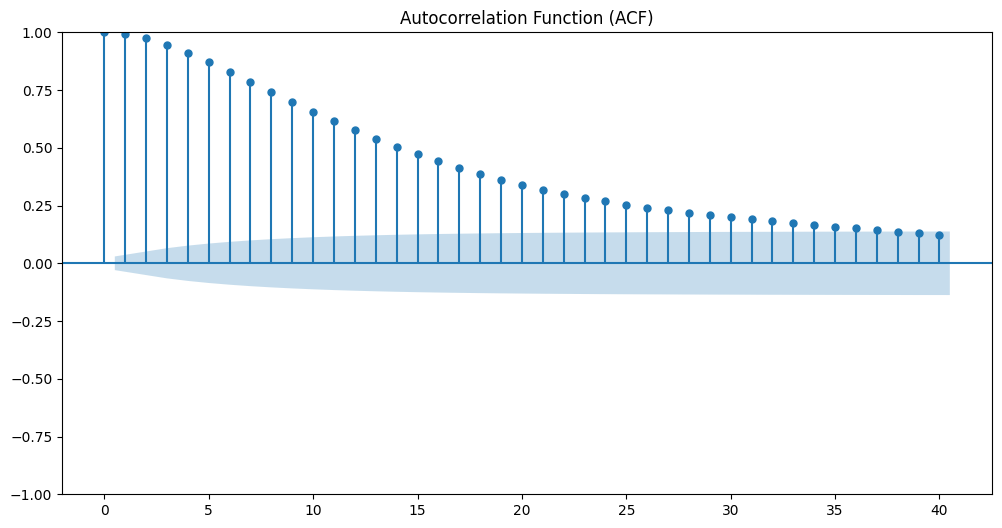

In [6]:
# Plotting Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(df_cleaned['Total\nvattenföring\n[m³/s]'], lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.show()

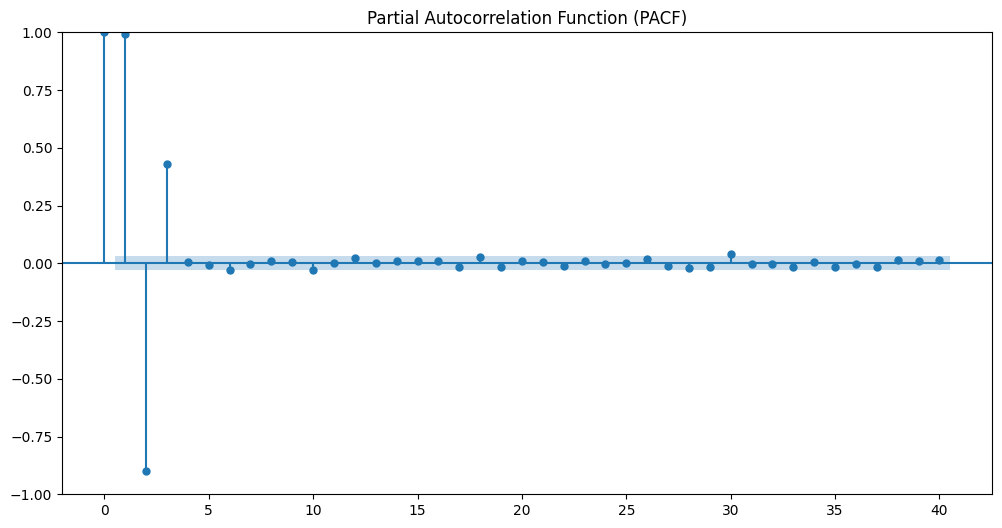

In [7]:
# Plotting Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(df_cleaned['Total\nvattenföring\n[m³/s]'], lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Fitting the model

Now we will try different combination of parameters for our ARIMA model based on the lags in ACF and PACF plots given above. We will then see how well they fit based on their AIC and BIC score (lower the better) and Log Likelihood (higher the better).

In [8]:
# Fitting the ARIMA model with (p=2, d=0, q=1)
model_201 = ARIMA(df_cleaned['Total\nvattenföring\n[m³/s]'], order=(2, 0, 1))
model_fit_201 = model_201.fit()

# Model Summary
print(model_fit_201.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                   SARIMAX Results                                   
Dep. Variable:     Total
vattenföring
[m³/s]   No. Observations:                 4383
Model:                        ARIMA(2, 0, 1)   Log Likelihood               21831.752
Date:                       Tue, 26 Dec 2023   AIC                         -43653.503
Time:                               21:14:34   BIC                         -43621.576
Sample:                           01-01-2010   HQIC                        -43642.238
                                - 12-31-2021                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0339      0.004      9.562      0.000       0.027       0.041
ar.L1          1.7975      0.004    417.572      0.000       1.789       1.

In [9]:
# Fitting the ARIMA model with (p=2, d=0, q=2)
model_202 = ARIMA(df_cleaned['Total\nvattenföring\n[m³/s]'], order=(2, 0, 2))
model_fit_202 = model_202.fit()

# Model Summary
print(model_fit_202.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                   SARIMAX Results                                   
Dep. Variable:     Total
vattenföring
[m³/s]   No. Observations:                 4383
Model:                        ARIMA(2, 0, 2)   Log Likelihood               21900.589
Date:                       Tue, 26 Dec 2023   AIC                         -43789.179
Time:                               21:14:44   BIC                         -43750.866
Sample:                           01-01-2010   HQIC                        -43775.661
                                - 12-31-2021                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0339      0.004      8.386      0.000       0.026       0.042
ar.L1          1.7629      0.007    249.913      0.000       1.749       1.

In [10]:
# Fitting the ARIMA model with (p=3, d=0, q=1)
model_301 = ARIMA(df_cleaned['Total\nvattenföring\n[m³/s]'], order=(3, 0, 1))
model_fit_301 = model_301.fit()

# Model Summary
print(model_fit_301.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                   SARIMAX Results                                   
Dep. Variable:     Total
vattenföring
[m³/s]   No. Observations:                 4383
Model:                        ARIMA(3, 0, 1)   Log Likelihood               21541.672
Date:                       Tue, 26 Dec 2023   AIC                         -43071.343
Time:                               21:15:16   BIC                         -43033.031
Sample:                           01-01-2010   HQIC                        -43057.825
                                - 12-31-2021                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0343      0.003     11.005      0.000       0.028       0.040
ar.L1          1.1293      0.014     77.973      0.000       1.101       1.

In [11]:
# Fitting the ARIMA model with (p=3, d=0, q=2)
model_302 = ARIMA(df_cleaned['Total\nvattenföring\n[m³/s]'], order=(3, 0, 2))
model_fit_302 = model_302.fit()

# Model Summary
print(model_fit_302.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                   SARIMAX Results                                   
Dep. Variable:     Total
vattenföring
[m³/s]   No. Observations:                 4383
Model:                        ARIMA(3, 0, 2)   Log Likelihood               21928.833
Date:                       Tue, 26 Dec 2023   AIC                         -43843.666
Time:                               21:15:36   BIC                         -43798.968
Sample:                           01-01-2010   HQIC                        -43827.895
                                - 12-31-2021                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0339      0.004      7.601      0.000       0.025       0.043
ar.L1          2.2608      0.047     48.214      0.000       2.169       2.

We can see in the table below that ARIMA (3,0,2) model achieved the best fit based on its lowest AIC and BIC values compared to other models.

In [12]:
# Comparing the AIC and BIC of all models
model_comparison = pd.DataFrame({
    'Model': ['ARIMA(2,0,1)', 'ARIMA(2,0,2)', 'ARIMA(3,0,1)', 'ARIMA(3,0,2)'],
    'AIC': [model_fit_201.aic, model_fit_202.aic, model_fit_301.aic, model_fit_302.aic],
    'BIC': [model_fit_201.bic, model_fit_202.bic, model_fit_301.bic, model_fit_302.bic],
})

model_comparison.set_index('Model', inplace=True)
model_comparison.sort_values(by='AIC')

,AIC,BIC
Model,,
"ARIMA(3,0,2)",-43843.666257,-43798.967837
"ARIMA(2,0,2)",-43789.178725,-43750.865793
"ARIMA(2,0,1)",-43653.503006,-43621.575563
"ARIMA(3,0,1)",-43071.343438,-43033.030506


# Forecasting

Now we will proceed with ARIMA (3,0,2) for forecasting the 'Total Waterflow' from January 2022 to December 2025.

In [13]:
# Forecasting using the ARIMA(3, 0, 2) model
forecast_start_date = df_cleaned.index[-1] + DateOffset(days=1)
forecast_end_date = '2025-12-31'

forecast_302 = model_fit_302.get_forecast(forecast_end_date)
forecast_index = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='D')
forecast_values = forecast_302.predicted_mean

forecast_df = pd.DataFrame({
    'Forecast': forecast_values
}, index=forecast_index)

forecast_df.head()

,Forecast
2022-01-01,0.030169
2022-01-02,0.029567
2022-01-03,0.029185
2022-01-04,0.028988
2022-01-05,0.028937


Now we calculate the variance by month in the forecasted 'Total Waterflow' values.

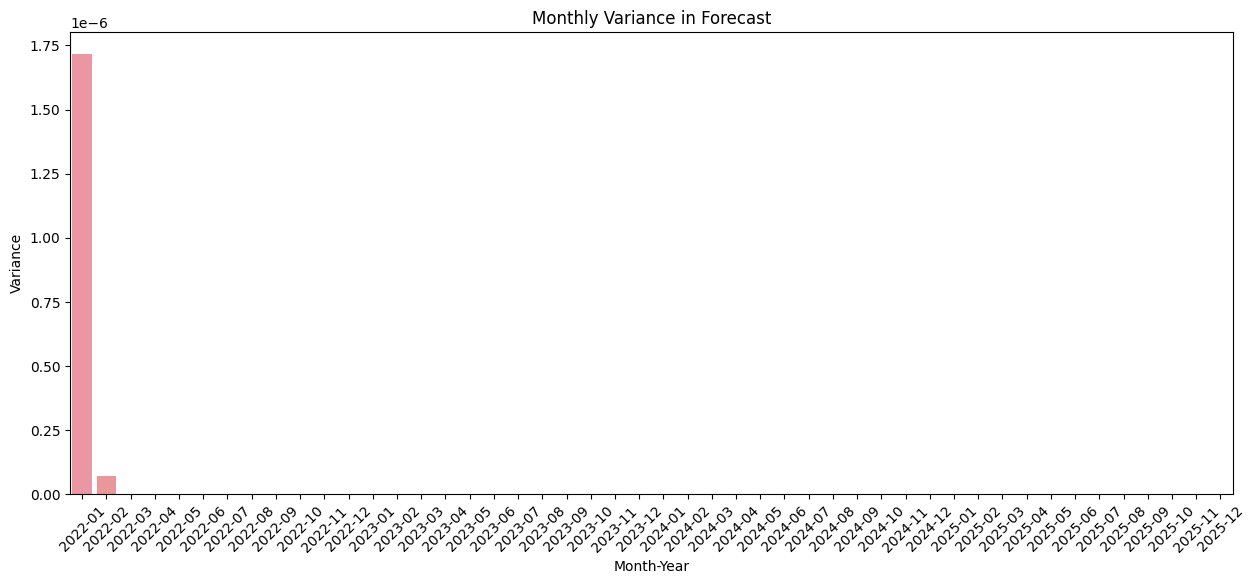

In [14]:
forecast_df['Year'] = forecast_df.index.year
forecast_df['Month'] = forecast_df.index.month

# Grouping by year and month to calculate monthly variance
monthly_variance = forecast_df.groupby(['Year', 'Month'])['Forecast'].var()
monthly_variance = monthly_variance.reset_index()
monthly_variance['Month-Year'] = monthly_variance['Year'].astype(str) + '-' + monthly_variance['Month'].astype(str).str.zfill(2)

# Plotting
plt.figure(figsize=(15, 6))
sns.barplot(x='Month-Year', y='Forecast', data=monthly_variance)
plt.xticks(rotation=45)
plt.title('Monthly Variance in Forecast')
plt.xlabel('Month-Year')
plt.ylabel('Variance')
plt.show()

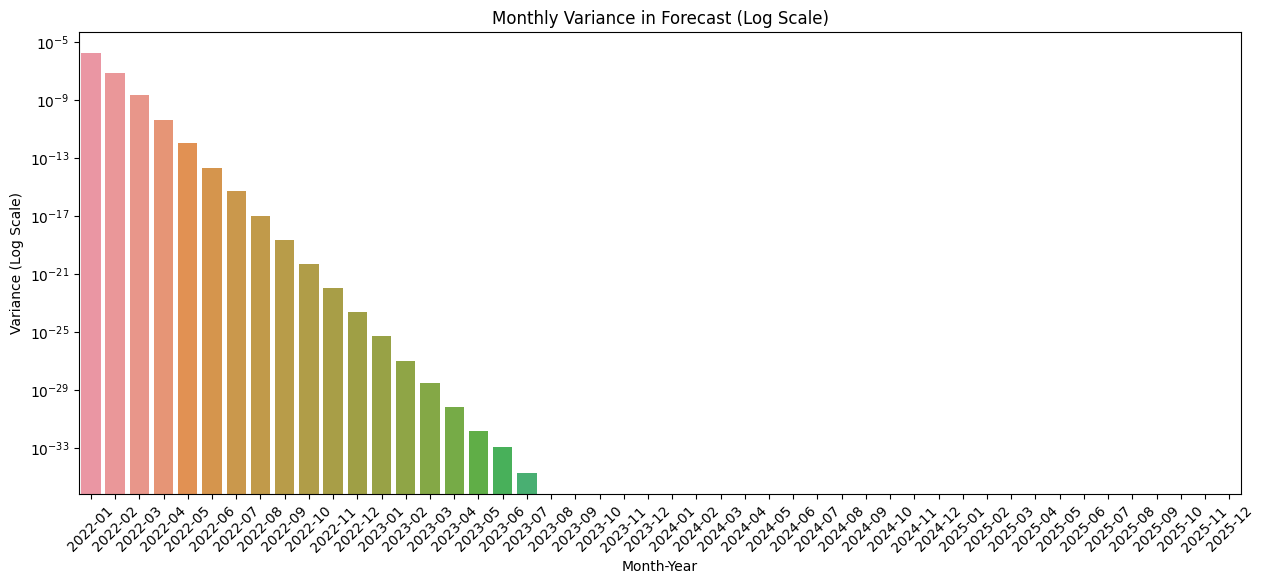

In [15]:
# Adjusting the graph to visulaize small variances

plt.figure(figsize=(15, 6))
sns.barplot(x='Month-Year', y='Forecast', data=monthly_variance)

plt.yscale('log')
plt.xticks(rotation=45)
plt.title('Monthly Variance in Forecast (Log Scale)')
plt.xlabel('Month-Year')
plt.ylabel('Variance (Log Scale)')
plt.show()

# Conclusion

From the plots above we can see that after a certain period the variance in forecasted  'Total Waterflow' drops significantly which leads us to several conclusions:

*   Model might be overfitting
*   Dataset does not exhibit strong trends
*   Not enough data for long term prediction


Due to these reasons we did not proceed with forecasting the 'Total Waterflow' of other lakes apart from the one above (MD MVM Id : 54)